### Алгоритмы сбора и анализа текстовых описаний продуктов

Копчев Владислав, 197

### Работа с vons.com

#### Сбор данных

In [1]:
import requests
from bs4 import BeautifulSoup
from lxml import etree
from io import StringIO, BytesIO
from math import ceil
import psycopg2
import json
import pandas as pd
import numpy as np

In [1]:
parser = etree.HTMLParser()

response_cat = requests.get('https://www.vons.com/shop/aisles.2053.html', 
                            headers = {
                                        'accept': 'application/json, text/javascript, */*; q=0.01',
                                        'accept-encoding': 'gzip, deflate, br',
                                        'accept-language': 'en-US,en;q=0.9',
                                        'cache-control': 'no-cache',
                                        'pragma': 'no-cache',
                                        'referer': 'https://www.vons.com/',
                                        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"'
                                }
                           )

html_code_cat = response_cat.text
tree_cat = etree.parse(StringIO(html_code_cat), parser)

categories = tree_cat.xpath('//div[@class="col-12 col-sm-12 col-md-4 col-lg-4 col-xl-3"]')  # 1st level
categories_dict = dict()
items_dict = dict()

categories_df = pd.DataFrame(columns=['Category', 'Category link', 'Subcategory', 'Subcategory link', 'Departament', 'Departament link', 'Item', 'Item link'])
items_df = pd.DataFrame(columns=['link', 'title', 'price', 'description', 'specifications', 'brand', 'model', 'upc', 'breadcrumbs'])

In [12]:
id = 0

for category in categories:
    if len(category.xpath('./a/div/h2/text()')) == 0 or len(category.xpath('./a/@href')) == 0:
        break
    cat_name = category.xpath('./a/div/h2/text()')[0]  # list of 1 element -> 1 this element
    cat_link = category.xpath('./a/@href')[0]
    categories_dict[cat_name] = cat_link

for category in categories_dict.keys():
    response_subcat = requests.get('https://www.vons.com' + categories_dict[category])
    html_code_subcat = response_subcat.text
    tree_subcat = etree.parse(StringIO(html_code_subcat), parser)

    subcategories = tree_subcat.xpath('//div[@class="categories-item aisle-item "] | //div[@class="categories-item aisle-item hidden-aisle d-none"]')
    subcategories_dict = dict()
    
    for subcategory in subcategories:
        if len(subcategory.xpath('./a/@href')) == 0 or len(subcategory.xpath('./a/@data-aisle-name')) == 0:
            break  # see созвон problem
        subcat_name = subcategory.xpath('./a/@data-aisle-name')[0]
        subcat_link = subcategory.xpath('./a/@href')[0]
        subcategories_dict[subcat_name] = subcat_link

    for subcategory in subcategories_dict.keys():
        response_dep = requests.get('https://www.vons.com' + subcategories_dict[subcategory])
        html_code_dep = response_dep.text
        tree_dep = etree.parse(StringIO(html_code_dep), parser)
        
        departaments = tree_dep.xpath('//div[@class="aisle-items filter-wrapper less height-auto"]')
        departaments_dict = dict()

        for departament in departaments:
            if len(departament.xpath('./div/span/a/text()')) == 0 or len(departament.xpath('./div/span/a/@href')) == 0:
                break
            dep_name = departament.xpath('./div/span/a/text()')[0]
            dep_link = departament.xpath('./div/span/a/@href')[0]
            departaments_dict[dep_name] = dep_link

        for departament in departaments_dict.keys():
            response_items = requests.get('https://www.vons.com' + departaments_dict[departament])
            html_code_items = response_items.text
            tree_items = etree.parse(StringIO(html_code_items), parser)

            items_count = int(tree_items.xpath('//span[@class="category-count"]/text()')[0][1:-1])  # to remove brackets
            pages_count = ceil(items_count / 30)

            for page in range(pages_count):
                response_page_items = requests.get('https://www.vons.com' + departaments_dict[departament] + '?sort=&page={}'.format(page + 1))
                html_code_page_items = response_page_items.text
                tree_page_page_items = etree.parse(StringIO(html_code_page_items), parser)

                page_items = tree_page_page_items.xpath('//a[@class="product-title"]')
                for page_item in page_items:
                    it_name = page_item.xpath('./text()')[0][33:-29]  # to remove spaces
                    it_link = page_item.xpath('./@href')[0]
                    items_dict[it_name] = it_link
                    categories_df = categories_df.append(
                        {
                            'Category': cat_name,
                            'Category link': cat_link,
                            'Subcategory': subcat_name,
                            'Subcategory link': subcat_link,
                            'Departament': dep_name,
                            'Departament link': dep_link,
                            'Item': it_name,
                            'Item link': it_link
                        }, ignore_index=True)
                    
                    id += 1
                    if id % 400 == 0:
                        print(id)

400
800
1200
1600
2000
2400
2800
3200
3600
4000
4400
4800
5200
5600
6000
6400
6800
7200
7600
8000
8400
8800
9200
9600
10000
10400
10800
11200
11600
12000
12400
12800
13200
13600
14000
14400
14800
15200
15600
16000
16400
16800
17200
17600
18000
18400
18800
19200
19600
20000
20400
20800
21200
21600
22000
22400
22800
23200
23600
24000
24400
24800
25200
25600
26000
26400
26800
27200
27600
28000
28400
28800
29200
29600
30000
30400
30800
31200
31600
32000
32400
32800
33200
33600
34000


In [3]:
# categories_df.to_csv('categories.csv')

In [17]:
items = set(pd.read_csv('categories.csv')['Item link'])

In [18]:
items_df = pd.DataFrame(columns=['link', 'title', 'price', 'description', 'specifications', 'brand', 'model', 'upc', 'breadcrumbs'])

In [19]:
id = 0

for item in items:
    link = 'https://www.vons.com' + item
        
    resp_item_page = requests.get(link, headers = {
                                            'accept': 'application/json, text/javascript, */*; q=0.01',
                                            'accept-encoding': 'gzip, deflate, br',
                                            'accept-language': 'en-US,en;q=0.9',
                                            'cache-control': 'no-cache',
                                            'pragma': 'no-cache',
                                            'referer': 'https://www.vons.com/',
                                            'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="96", "Google Chrome";v="96"'
                                        })
        
    html_item_page = resp_item_page.text
    tree_item_page = etree.parse(StringIO(html_item_page), parser)
    
    if len(tree_item_page.xpath('//script[@type="application/ld+json"]/text()')) > 1:  # there are some problems... see how many as diff of tables later
        title = tree_item_page.xpath('//title/text()')[0]
        price = json.loads(tree_item_page.xpath('//script[@type="application/ld+json"]/text()')[1])['offers']['price'] + '$'
        old_price = price
        images = tree_item_page.xpath('//picture[@class="img-responsive center-block"]/source/@srcset')
        for img in images:
            img = 'https:' + img
        breadcrumbs = tree_item_page.xpath('//li[@class="pdpCrumbs-list"]/a/text()')
        description = tree_item_page.xpath('//div[@class="content-detail body-m"]/div/text()')
        promotion_message = tree_item_page.xpath('//p[@id="banner-label"]/text()')
        specifications = tree_item_page.xpath('//div[@class="col-12 col-sm-12 col-md-6 col-lg-6 col-xl-6 flour body-m"]/text()')
        upc = tree_item_page.xpath('//div[@class="container-fluid product-details-wrapper"]/@data-upc')[0]
        brand = json.loads(tree_item_page.xpath('//script[@type="application/ld+json"]/text()')[1])['brand']['name']
        model = title.replace(brand + ' ', '')
        
        items_df = items_df.append({
            'link': link,
            'title': title,
            'price': price,
            'breadcrumbs': breadcrumbs,
            'description': description,
            'specifications': specifications,
            'brand': brand,
            'model': model,
            'upc': upc
        }, ignore_index=True)
        
        id += 1
        
        if id % 400 == 0:
            print(id, '/', len(items), sep='')

15200/23301
15600/23301
16000/23301
16400/23301
16800/23301
17200/23301
17600/23301
18000/23301
18400/23301
18800/23301
19200/23301
19600/23301
20000/23301
20400/23301
20800/23301
21200/23301
21600/23301
22000/23301
22400/23301
22800/23301


In [20]:
items_df.to_csv('items.csv')

#### Кластеризация

In [876]:
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd

In [877]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
data_df = pd.read_csv('items.csv')
data = list(pd.read_csv('items.csv')['description'])

In [878]:
embeddings = np.loadtxt('emb.txt')

In [999]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=2, 
                         metric='cosine').fit_transform(embeddings)

In [1000]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                            metric='euclidean',                      
                            cluster_selection_method='eom',
                            prediction_data=True).fit(umap_embeddings)

In [1001]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

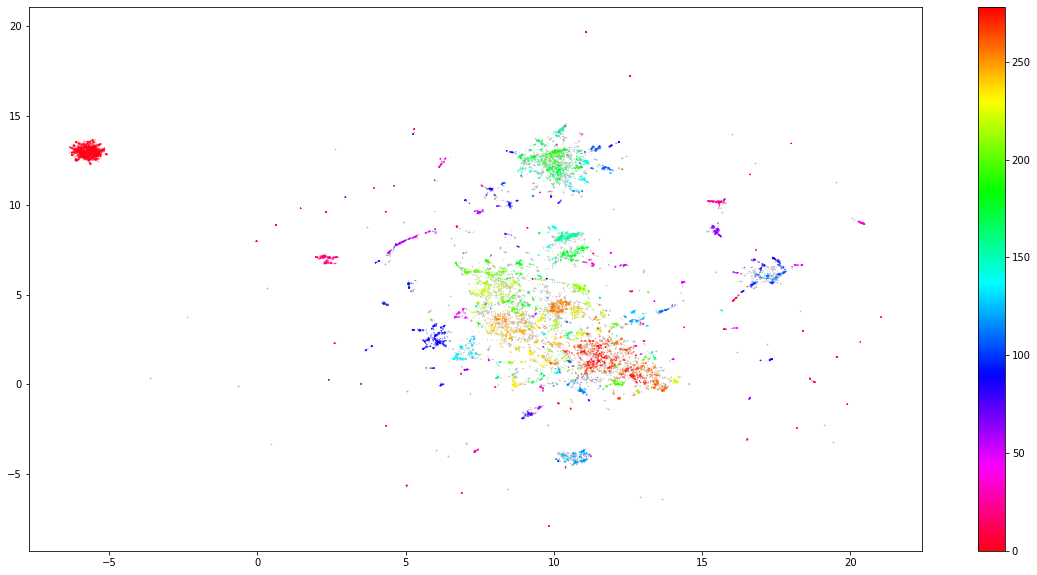

In [1002]:
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [1003]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

docs_per_topic.loc[1, 'Doc'] = docs_per_topic.loc[docs_per_topic.shape[0] - 1, 'Doc']
docs_per_topic = docs_per_topic.drop([docs_per_topic.shape[0] - 1])

docs_per_topic

,Topic,Doc
0,-1,"['\n Flour, Who..."
1,0,['\n Garlic Bas...
2,1,['\n Bakery Cak...
3,2,"['\n Candy, Ass..."
4,3,['\n Energy Dri...
...,...,...
274,273,['\n Beef & Bro...
275,274,['\n Extra Long...
276,275,"['\n Chicken, S..."
277,276,['\n Vegetarian...


In [1004]:
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [1005]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,7520
1,0,1842
90,89,456
19,18,304
211,210,245
64,63,215
274,273,195
279,278,195
168,167,194
256,255,192


In [1006]:
topic_sizes['Topic'].size

280

In [1007]:
top_n_words[-1][:10]

[('free', 0.006193839714209225),
 ('questions', 0.006035623731862958),
 ('gluten', 0.005936865025345209),
 ('800', 0.005933341707970102),
 ('natural', 0.005756581502571135),
 ('organic', 0.005719071326378803),
 ('visit', 0.005669740357789708),
 ('certified', 0.005609348534259401),
 ('non', 0.0055004850084320045),
 ('serving', 0.005473624694134958)]

In [1008]:
top_n_words[0][:10]

[('sauce', 0.039297119605523415),
 ('garlic', 0.03615617899074326),
 ('flavor', 0.021081170026157253),
 ('pepper', 0.01721232075936203),
 ('salad', 0.017110641619946788),
 ('recipes', 0.0168911639561351),
 ('chili', 0.016058214267256083),
 ('peppers', 0.01566790651938805),
 ('pasta', 0.015402048398694955),
 ('sense', 0.015284891053165679)]

In [1009]:
top_n_words[99][:10]

[('cake', 0.16870765306064298),
 ('chocolate', 0.1514206456367216),
 ('cookies', 0.13878088807653186),
 ('count', 0.11020388743981879),
 ('frosted', 0.09314329674180821),
 ('chip', 0.09060860337415211),
 ('brownie', 0.08745257591942099),
 ('ring', 0.0848106070342565),
 ('swirls', 0.08388425738233496),
 ('mousse', 0.0800669867629452)]

In [1010]:
top_n_words[213][:10]

[('juice', 0.1583517595753971),
 ('7799', 0.1135426341655426),
 ('237', 0.10931549778851536),
 ('orange', 0.10854744537115171),
 ('concentrate', 0.10389793224651085),
 ('tropicana', 0.09543142132519969),
 ('brazil', 0.0918146463582313),
 ('pulp', 0.08810259058418826),
 ('pasteurized', 0.059123930899865555),
 ('contains', 0.04735920607437663)]

In [1011]:
top_n_words[50][:10]

[('nonstick', 0.14411607982863872),
 ('china', 0.11844878420818934),
 ('durable', 0.10787735516375946),
 ('safe', 0.09454496743189827),
 ('dishwasher', 0.08776822165663124),
 ('heat', 0.08205592850317578),
 ('inch', 0.0812899204608053),
 ('construction', 0.080753752540652),
 ('goodcook', 0.0787171327659945),
 ('pan', 0.06904150730480604)]

In [1012]:
topic_sizes.shape

(280, 2)

#### Рекомендательная система

In [1013]:
test_points = ["Wholesome snacks: popcorner's delicious popped corn snacks are drizzled in sunflower oil with a pinch of sea salt, our chips are never fried. No gluten, no nuts. Just simple ingredients for better flavor"]

# https://www.amazon.com/Popcorners-Snacks-Gluten-flavor-Variety/dp/B08D7JM1X2/ref=sr_1_2?crid=1HNJAW9GVP9PQ&keywords=cips&qid=1654342491&sprefix=cip%2Caps%2C167&sr=8-2&th=1

In [1014]:
test_embeddings = model.encode(test_points, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [1015]:
test_embeddings = umap.UMAP(n_neighbors=15, 
        n_components=2, 
        metric='cosine').fit_transform(test_embeddings)

In [1016]:
test_labels, strengths = hdbscan.approximate_predict(cluster, test_embeddings)

In [1017]:
test_labels

array([5], dtype=int32)

In [1018]:
top_n_words[-1][:10]

[('free', 0.006193839714209225),
 ('questions', 0.006035623731862958),
 ('gluten', 0.005936865025345209),
 ('800', 0.005933341707970102),
 ('natural', 0.005756581502571135),
 ('organic', 0.005719071326378803),
 ('visit', 0.005669740357789708),
 ('certified', 0.005609348534259401),
 ('non', 0.0055004850084320045),
 ('serving', 0.005473624694134958)]

In [1019]:
ind = docs_df.loc[docs_df['Topic'] == test_labels[0], 'Doc'].index
data_df.loc[ind, 'link']

1587     https://www.vons.com/shop/product-details.9600...
2267     https://www.vons.com/shop/product-details.9600...
3090     https://www.vons.com/shop/product-details.9600...
5142     https://www.vons.com/shop/product-details.9600...
5435     https://www.vons.com/shop/product-details.1050...
9392     https://www.vons.com/shop/product-details.1050...
10554    https://www.vons.com/shop/product-details.9600...
11470    https://www.vons.com/shop/product-details.9600...
13497    https://www.vons.com/shop/product-details.1050...
14173    https://www.vons.com/shop/product-details.1050...
16061    https://www.vons.com/shop/product-details.9600...
17051    https://www.vons.com/shop/product-details.9600...
17389    https://www.vons.com/shop/product-details.9600...
18445    https://www.vons.com/shop/product-details.9600...
19360    https://www.vons.com/shop/product-details.9600...
19572    https://www.vons.com/shop/product-details.1050...
20457    https://www.vons.com/shop/product-details.9600.

In [1020]:
test_points2 = ["NESPRESSO VERTUOLINE VARIETY PACK ASSORTMENT: This Nespresso coffee assortment offers 30 Nespresso Pods in a variety of 3 best-selling coffee blends for the Nespresso VertuoLine System.10 Stormio, 10 Odacio, 10 Melozio. INTENSITY: This assortment will let you explore the rich tastes of the following Nespresso Capsules: Stormio (Intensity 8), Odacio (Intensity 7) and Melozio (Intensity 6). It's the perfect choice to discover a distinctive range of extraordinary coffees. COFFEE BREWS 7.77 OZ : These Nespresso VertuoLine pods provide you with a 7.77 oz serving of coffee which is perfect for a longer drinking experience"]
# https://www.amazon.com/Nespresso-Vertuoline-Seller-Assortment-Count/dp/B01N05APQY/ref=lp_16310101_1_2

test_embeddings2 = model.encode(test_points2, show_progress_bar=True)
test_embeddings2 = umap.UMAP(n_neighbors=15, 
        n_components=2, 
        metric='cosine').fit_transform(test_embeddings2)
test_labels2, strengths = hdbscan.approximate_predict(cluster, test_embeddings2)
top_n_words[test_labels2[0]][:10]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[('florida', 0.23818733921845478),
 ('juice', 0.12086217876607155),
 ('heinz', 0.09674204697894863),
 ('orange', 0.0901729267416041),
 ('ketchup', 0.08155329091032834),
 ('floridasnatural', 0.07347140133215149),
 ('6600', 0.07347140133215149),
 ('oranges', 0.06645017348665587),
 ('657', 0.06416052361638346),
 ('bask', 0.05814961608506811)]